# Data Analysis 2
## In this analysis we will find the three best selling products grouped by the number of days it takes to manufacture them

First we connect to the cloud database, run an SQL query for the necessary data and store it in pandas dataframes.
This analysis requires three tables: ``SalesOrderDetail``, ``SpecialOfferProduct`` and ``Product``. We could join the tables in a single SQL query, but for simplicity's sake let's merge them with pandas.

In [1]:
import pandas.io.sql as sqlio
import psycopg2
from config import config

params = config()
conn = psycopg2.connect(**params)
sql1 = 'SELECT * FROM \"SalesOrderDetail\";'
sql2 = 'SELECT * FROM \"SpecialOfferProduct\";'
sql3 = 'SELECT * FROM \"Product\";'
salesOrderDetail = sqlio.read_sql_query(sql1, conn)
specialOfferProduct = sqlio.read_sql_query(sql2, conn)
product = sqlio.read_sql_query(sql3, conn)
conn.close()

Let's inspect the dataframes.

In [2]:
from IPython.display import display

display(salesOrderDetail.head(3))
display(specialOfferProduct.head(3))
display(product.head(3))

,SalesOrderID,SalesOrderDetailID,CarrierTrackingNumber,OrderQty,ProductID,SpecialOfferID,UnitPrice,UnitPriceDiscount,LineTotal,rowguid,ModifiedDate
0,43659,1,4911-403C-98,1,776,1,2024.994,0.0,2024.994,B207C96D-D9E6-402B-8470-2CC176C42283,2011-05-31
1,43659,2,4911-403C-98,3,777,1,2024.994,0.0,6074.982,7ABB600D-1E77-41BE-9FE5-B9142CFC08FA,2011-05-31
2,43659,3,4911-403C-98,1,778,1,2024.994,0.0,2024.994,475CF8C6-49F6-486E-B0AD-AFC6A50CDD2F,2011-05-31


,SpecialOfferID,ProductID,rowguid,ModifiedDate
0,1,680,BB30B868-D86C-4557-8DB2-4B2D0A83A0FB,2011-04-01
1,1,706,B3C9A4B1-2AE6-4CBA-B552-1F206C9F4C1F,2011-04-01
2,1,707,27B711FE-0B77-4EA4-AD1A-7C239956BEF4,2011-04-01


,ProductID,Name,ProductNumber,MakeFlag,FinishedGoodsFlag,Color,SafetyStockLevel,ReorderPoint,StandardCost,ListPrice,...,ProductLine,Class,Style,ProductSubcategoryID,ProductModelID,SellStartDate,SellEndDate,DiscontinuedDate,rowguid,ModifiedDate
0,1,Adjustable Race,AR-5381,False,False,None,1000,750,0.0,0.0,...,None,None,None,NaN,NaN,2008-04-30,NaT,None,694215B7-08F7-4C0D-ACB1-D734BA44C0C8,2014-02-08 10:01:36.827
1,2,Bearing Ball,BA-8327,False,False,None,1000,750,0.0,0.0,...,None,None,None,NaN,NaN,2008-04-30,NaT,None,58AE3C20-4F3A-4749-A7D4-D568806CC537,2014-02-08 10:01:36.827
2,3,BB Ball Bearing,BE-2349,True,False,None,800,600,0.0,0.0,...,None,None,None,NaN,NaN,2008-04-30,NaT,None,9C21AED2-5BFA-4F18-BCB8-F11638DC2E4E,2014-02-08 10:01:36.827


Now let's merge them with pandas.

In [3]:
import pandas as pd

df1 = pd.merge(salesOrderDetail, specialOfferProduct, how = "inner", on = ['ProductID', 'SpecialOfferID'], suffixes = ('_sod', '_sop'))
df1 = pd.merge(df1, product, how = "inner", on = 'ProductID', suffixes = ('', '_p'))

Here is the resulting dataframe.

In [4]:
display(df1.head(3))

,SalesOrderID,SalesOrderDetailID,CarrierTrackingNumber,OrderQty,ProductID,SpecialOfferID,UnitPrice,UnitPriceDiscount,LineTotal,rowguid_sod,...,ProductLine,Class,Style,ProductSubcategoryID,ProductModelID,SellStartDate,SellEndDate,DiscontinuedDate,rowguid,ModifiedDate
0,43659,1,4911-403C-98,1,776,1,2024.994,0.0,2024.994,B207C96D-D9E6-402B-8470-2CC176C42283,...,M,H,U,1.0,19.0,2011-05-31,2012-05-29,None,02935111-A546-4C6D-941F-BE12D42C158E,2014-02-08 10:01:36.827
1,43661,25,4E0A-4F89-AE,4,776,1,2024.994,0.0,8099.976,E8E15B60-3A73-4507-9368-A4FB27B6EE0B,...,M,H,U,1.0,19.0,2011-05-31,2012-05-29,None,02935111-A546-4C6D-941F-BE12D42C158E,2014-02-08 10:01:36.827
2,43665,70,19F0-4638-8E,1,776,1,2024.994,0.0,2024.994,0D2A679C-6C8E-4CC2-8A55-B8DB83937AC2,...,M,H,U,1.0,19.0,2011-05-31,2012-05-29,None,02935111-A546-4C6D-941F-BE12D42C158E,2014-02-08 10:01:36.827


As we only need to know the products' name, how much of them were sold and how long they take to manufacture, we can drop most columns to make data visualization easier. At the same time, we'll create two dataframes, one storing the order quantity for each product and the other storing how long it takes to manufacture each product.

In [5]:
dfOQ = df1[['Name', 'OrderQty']].groupby('Name').sum()
dfDTM = df1[['Name', 'DaysToManufacture']].groupby('Name').max()

Now let's merge the two dataframes into one dataframe that stores how much each product was ordered and how long it takes to be manufactured, sorted by descending order of order quantity.

In [6]:
df2 = pd.merge(
    dfOQ,
    dfDTM,
    how = "inner",
    on = 'Name',
    suffixes = ('_oq', '_dtm')
).sort_values('OrderQty', ascending = False)
df2['Name'] = df2.index
df2 = df2[['OrderQty', 'DaysToManufacture']].reset_index()

Let's inspect the result.

In [7]:
display(df2.head(3))

,Name,OrderQty,DaysToManufacture
0,AWC Logo Cap,8311,0
1,Water Bottle - 30 oz.,6815,0
2,"Sport-100 Helmet, Blue",6743,0


Now we group by days to manufacture and store only the top three results for each time range.

In [8]:
df3 = df2.groupby('DaysToManufacture').head(3).sort_values('DaysToManufacture').reset_index(drop = True)

Let's see the resulting dataframe.

In [9]:
display(df3)

,Name,OrderQty,DaysToManufacture
0,AWC Logo Cap,8311,0
1,Water Bottle - 30 oz.,6815,0
2,"Sport-100 Helmet, Blue",6743,0
3,"LL Road Frame - Black, 52",1581,1
4,ML Mountain Handlebars,1465,1
5,"ML Road Frame-W - Yellow, 44",1435,1
6,"HL Mountain Frame - Silver, 38",1206,2
7,"ML Road Frame-W - Yellow, 38",895,2
8,"HL Mountain Frame - Black, 38",659,2
9,"Mountain-200 Black, 38",2977,4


There we have it, the three best selling products by days to manufacture. Let's plot a graph to better visualize the relationship between time to manufacture and number of sales.

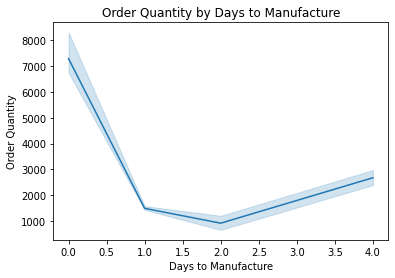

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.lineplot(x = 'DaysToManufacture', y = 'OrderQty', data = df3)
g.set(title = 'Order Quantity by Days to Manufacture', xlabel = 'Days to Manufacture', ylabel = 'Order Quantity')
plt.show()

Finally, let's save the resulting dataframe to a ``.csv`` file.

In [11]:
df3.to_csv('results/analysis2.csv')